# Prueba 1: Análisis de Sentimientos de Twitter

A continuación se presenta un problema clásico en el análisis de texto: Extraer el sentimiento asociado a un texto. 

Para esto, utilizaremos una base de datos provenientes de CrowdFlower. 

Para descargar los datos puede ejecutar el siguiente código:
wget https://www.crowdflower.com/wp-content/uploads/2016/07/text_emotion.csv 

El objetivo general de esta prueba es alcanzar el mejor desempeño posible para clasificar si un tweet es positivo o negativo.
Para medir el desempeño, se evaluará con un conjunto de datos del cuál no tendrán acceso. De esta manera evitaremos que los modelos aprendan información sobre el conjunto de validación.
Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook, archivos auxiliares y csv).
Una vez terminada la prueba, comprime la carpeta y sube el .zip a la sección correspondiente.


# Objetivos

Para alcanzar el objetivo general, su trabajo se puede desagregar en los siguientes puntos:
1. Generar un análisis exploratorio sobre los datos contenidos en el DataFrame, considerando palabras más comunes y distribución de las clases en el vector objetivo.
2. Preprocesamiento de Texto:
Para trabajar adecuadamente con texto, debemos preprocesar y posteriormente representar cada oración como un conjunto de características.
Para preprocesar los tweets, debemos transformarlos a lower case. Un problema recurrente en el análisis de texto es la alta ocurrencia de palabras comunes.
 - Se recomienda eliminarlas mediante la declaración de stopwords. Para generar la exclusión de stopwords, podemos utilizar la librería nltk (Natural Language ToolKit) y descargar los stopwords con la siguiente instrucción.
 
    - Puede refinar los atributos a capturar mediante el proceso de lemantización (la reducción de variadas palabras con un tronco léxico común; ejemplo: Organización, Organiza, y Organizado presentan organi_ como tronco léxico en comúmn) o Stemming (la reducción de una palabra a una expresión generalizable). Cabe destacar que ésta última carece de análisis morfológico del lenguaje. 

    - Posterior a la refinación y preprocesamiento de las palabras, podemos representar cada oración en una matriz (o corpus) que permitirá reflejar la cantidad de ocurrencias de palabra en un registro. Para ello, pueden hacer uso de las librerías de preprocesamiento sklearn.feature_extraction.text.CountVectorizer o sklearn.feature_extraction.text.TfidfVectorizer . 
    - De esta manera, tendremos un conjunto de características es mediante la frecuencia de ocurrencia de una palabra o término en el texto.

In [1]:
import nltk 
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
rep_seed = 3504
from sklearn.model_selection import GridSearchCV

import pickle

import lec10_graphs as afx



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eduardo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


3. Preparación del vector objetivo y las matrices de entrenamiento y validación:
Nos interesa trabajar con dos tipos de emociones: positivas o negativas. Para ello deberá generar la recodificación de cada una de las clases en una de las dos emociones:
        
Original | Recodificación
---|---
'worry' | Negativa
'happiness' | Positiva
'sadness' | Negativa
'love' | Positiva
'surprise' | Positiva
'fun' | Positiva
'relief' | Positiva
'hate' | Negativa
'empty' | Negativa
'enthusiasm' | Positiva
'boredom' | Negativa
'anger' | Negativa
 
 
 
Si el tweet está asignado como neutral , clasifíquelo aleatoriamente entre positivo o negativo.
 
4. Entrenamiento de modelos:
En base a los modelos vistos en clase, implemente por lo menos 5. Para cada uno de ellos justifique la elección de hiperparámetros. Si implementa búsqueda de grilla para cada uno de ellos, defina el rango de valores a tomar en cada hiperparámetro.
Reporte el desempeño de cada modelo en las muestras de entrenamiento y validación. Comente sobre la capacidad de generalización de cada uno de ellos haciendo uso de los conceptos vistos en el curso.
5. Seleccione los 2 mejores modelos, serialicelos y envíelos a evaluación. Recuerde que el modelo serializado debe ser posterior al fit , para poder ejecutar predict en los nuevos datos.
6. La evaluación del modelo será realizada en función a un conjunto de datos reservados al cual no tienen acceso.

# Preparación del espacio de trabajo

In [2]:
import nltk 
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
df = pd.read_csv('training_tweets.csv').drop(columns='Unnamed: 0')
positivos = {('happiness','love','surprise','fun','relief','hate','empty','enthusiasm','boredom'):1,('worry','sadness','hate','empty','boredom','anger'):0}
list_positivos = ['happiness','love','surprise','fun','relief','hate','empty','enthusiasm','boredom']
list_negativos = ['worry','sadness','hate','empty','boredom','anger']
sentiments = df['sentiment']

In [4]:
df.query("sentiment!='neutral'",inplace=True)

In [5]:
df.sentiment.replace(list_positivos, 1, inplace=True)
df.sentiment.replace(list_negativos, 0, inplace=True)
df['randNumCol'] = np.random.randint(0, 2, df.shape[0])
df['sentiment_re'] = np.where(df['sentiment']=='neutral',df['randNumCol'],df['sentiment'])

In [6]:
df.head()

,content,sentiment,randNumCol,sentiment_re
0,Happy Mama's day to all mothers,1,0,1
1,@LysdelTellez I am lost. Please help me find a...,0,1,0
2,"@BoomKatt yes yes I AM, networking whore to th...",1,0,1
4,now i am doing the MicroEconomics project iha...,0,1,0
6,@jackEO313 at first i thought bar life meant y...,1,1,1


In [7]:
def preprocess_strings(string_array):
    # ingresamos stopwords y stemmer
    stopwords = nltk.corpus.stopwords.words("english")
    # con el stemmer reducimos las palabras a una raíz semántica común.
    stemmer = nltk.stem.snowball.SnowballStemmer("english")
    # holder de strings a nivel de array
    string_array_holder = []
    # por cada string en el array
    for string in string_array:
        # holder de palabras en cada string
        string_holder = []
        # separamos (tokenizamos) cada palabra en el string
        tokenized_strings = nltk.word_tokenize(string)
        # por cada palabra en el string
        for token in tokenized_strings:
            # lowercase
            token = token.lower()
            # reemplazamos todo caracter noalfanumérico a nada.
            token = re.sub(re.compile("[^A-Za-z0-9]+"), "", token)
            # si la palabra no es vacía y no se encuentra a nivel de stopwords
            if token != "" and token not in stopwords:
                # reducimos a la raíz semántica
                token = stemmer.stem(token)
            # si es que es válida
            if token != "":
                # concatenamos
                string_holder.append(token)
        # concatenamos a nivel de holders
        string_array_holder.append(string_holder)
    # devolvemos
    
    return string_array_holder

In [8]:
stem = preprocess_strings(df['content'])

In [9]:
len(stem)

23549

In [10]:
emptydf = []
for i in stem:
    a=' '.join(i)
    emptydf.append(a)
lemm = pd.DataFrame(emptydf)
lemm.info()
df.reset_index(inplace=True)
df['content']=lemm

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23549 entries, 0 to 23548
Data columns (total 1 columns):
0    23549 non-null object
dtypes: object(1)
memory usage: 184.1+ KB


In [11]:
df['sentiment_re'] = df['sentiment_re'].apply(pd.to_numeric)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23549 entries, 0 to 23548
Data columns (total 5 columns):
index           23549 non-null int64
content         23549 non-null object
sentiment       23549 non-null int64
randNumCol      23549 non-null int64
sentiment_re    23549 non-null int64
dtypes: int64(4), object(1)
memory usage: 920.0+ KB


In [13]:
df['sentiment_re'].value_counts()
df.dropna(inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23549 entries, 0 to 23548
Data columns (total 5 columns):
index           23549 non-null int64
content         23549 non-null object
sentiment       23549 non-null int64
randNumCol      23549 non-null int64
sentiment_re    23549 non-null int64
dtypes: int64(4), object(1)
memory usage: 1.1+ MB


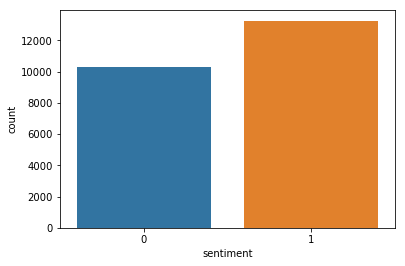

In [15]:
sns.countplot(data=df, x='sentiment',)

Definimos el problema como un problema de clasificación.

### Las clases estan relativamente balanceadas, de todas formas para evitar distorsiones en la métrica, utilizaremos F1-macro para encontrar una métrica que mida ambas clases con igual peso ambas, dado que no conocemos el *problema de negocio* y si alguna de estas métricas es mas importante que la otra

In [16]:
cv = CountVectorizer(stop_words='english',max_features=1000)

In [17]:
cv_fit = cv.fit_transform(df['content'])

In [18]:
cv_fit

<23549x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 114392 stored elements in Compressed Sparse Row format>

In [19]:
words = cv.get_feature_names()

In [20]:
word_freq = cv_fit.toarray()

In [21]:
type(df['content'])

pandas.core.series.Series

In [22]:
df_cv = pd.DataFrame(word_freq,columns=words)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df_cv,
                                                  df['sentiment_re'],
                                                  test_size=.33,
                                                  random_state=3504)

# Naive Bayes

In [24]:
NB = BernoulliNB()

In [25]:
NB.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [26]:


y_hat = NB.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.66      0.63      0.64      3392
           1       0.72      0.75      0.73      4380

   micro avg       0.70      0.70      0.70      7772
   macro avg       0.69      0.69      0.69      7772
weighted avg       0.69      0.70      0.69      7772



# Logistic Regression


In [27]:
lr = LogisticRegression(random_state=3540, penalty='l2')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=3540, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [28]:
y_hat = lr.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.67      0.60      0.63      3392
           1       0.71      0.78      0.74      4380

   micro avg       0.70      0.70      0.70      7772
   macro avg       0.69      0.69      0.69      7772
weighted avg       0.70      0.70      0.70      7772



Utilizamos GridSearch para optimizar los hiperparámtros de la regresión

In [29]:

grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression(random_state=3504, fit_intercept=False)
logreg_cv=GridSearchCV(logreg,grid,cv=5, scoring='f1', n_jobs=-1)
logreg_cv.fit(X_train,y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=3504, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [30]:
logreg_cv.best_params_

{'C': 0.1, 'penalty': 'l2'}

In [31]:
y_hat = logreg_cv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.66      0.64      0.65      3392
           1       0.73      0.75      0.74      4380

   micro avg       0.70      0.70      0.70      7772
   macro avg       0.70      0.70      0.70      7772
weighted avg       0.70      0.70      0.70      7772



#  Arbol de clasificación

In [32]:

dtc = DecisionTreeClassifier()

In [33]:
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [34]:
y_hat = dtc.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.57      0.59      0.58      3392
           1       0.68      0.66      0.67      4380

   micro avg       0.63      0.63      0.63      7772
   macro avg       0.62      0.63      0.62      7772
weighted avg       0.63      0.63      0.63      7772



In [35]:
try:
    dec_tree_grid_cv = pickle.load(open('dec_tree_grid_cv.sav','rb'))
except:

    dec_tree_grid_cv = GridSearchCV(DecisionTreeClassifier(),
                                        # evaluamos 10 escenarios
                                       {'min_samples_split': np.linspace(0.1, 1.0, 10),
                                        # implementando 2 criterios de partición
                                        'criterion': ['gini', 'entropy'],
                                        # con una profundidad de ramas hasta 5
                                       'max_depth': np.linspace(1, 5, 5),
                                        # evaluando 10 escenarios
                                       'min_samples_leaf': np.linspace(0.1, 0.5, 10)},
                                    # Con 3 validaciones cruzadas
                                    cv=3,
                                    # Ocupando todos los núcleos del computador
                                    n_jobs=-1, scoring='f1-macro').fit(X_train, y_train)

    pickle.dump(dec_tree_grid_cv, open('dec_tree_grid_cv.sav','wb'))


In [36]:
dec_tree_grid_cv.best_params_

{'criterion': 'gini',
 'max_depth': 1.0,
 'min_samples_leaf': 0.1,
 'min_samples_split': 0.1}

In [37]:
y_hat = dec_tree_grid_cv.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3392
           1       0.56      1.00      0.72      4380

   micro avg       0.56      0.56      0.56      7772
   macro avg       0.28      0.50      0.36      7772
weighted avg       0.32      0.56      0.41      7772



# Random Forest

In [38]:
voting_rf = RandomForestClassifier(oob_score=True, random_state=11238).fit(X_train, y_train)

In [39]:
print(classification_report(y_test, voting_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61      3392
           1       0.70      0.69      0.69      4380

   micro avg       0.66      0.66      0.66      7772
   macro avg       0.65      0.65      0.65      7772
weighted avg       0.66      0.66      0.66      7772



# AdaBoost

In [40]:
decision_stump = DecisionTreeClassifier(max_depth=5, random_state=11238).fit(X_train, y_train)

In [41]:
adaboost_classifier = AdaBoostClassifier(base_estimator=logreg_cv.best_estimator_, random_state=3504).fit(X_train, y_train)

In [42]:
print(classification_report(y_test, adaboost_classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.66      0.47      0.55      3392
           1       0.66      0.82      0.73      4380

   micro avg       0.66      0.66      0.66      7772
   macro avg       0.66      0.64      0.64      7772
weighted avg       0.66      0.66      0.65      7772



# Voting Classifier

In [43]:
# definimos el comité de clasificadores en una lista de tuplas


estimators3 = [('Linear Discriminant Analysis', LinearDiscriminantAnalysis()),
              ('Logistic Regression', LogisticRegression(random_state=rep_seed,fit_intercept=False)),
              
              ('Naive Bayes', BernoulliNB())
             ]



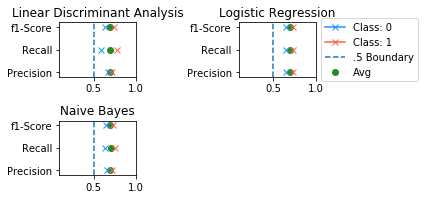

In [44]:
for index, value in enumerate(estimators3):
    plt.subplot(3, 2,  index + 1)
    plt.title(value[0])
    class_pred = value[1].fit(X_train, y_train).predict(X_test)
    afx.plot_classification_report(y_test, class_pred)
    plt.axvline(.5, label='.5 Boundary', linestyle='--')
    plt.xlim((0.1, 1.0))
    if (index + 1) % 2 == 0:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

Generamos una función que nos permite buscar cual es el mejor f-1 macro de una combinación de pesos, de forma de elegir el mejor

In [45]:

df_n = pd.DataFrame(columns=('w1', 'w2', 'w3', 'f1'))

i = 0
for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range(1,4):

            if len(set((w1,w2,w3))) == 1: # skip if all weights are equal
                continue
            voting_classifier = VotingClassifier(estimators3,voting='soft',weights=(w1,w2,w3)).fit(X_train, y_train)
            #print((w1,w2,w3))
            #print(classification_report(y_test, voting_classifier.predict(X_test)))
            
            df_l = pd.DataFrame(classification_report(y_test, voting_classifier.predict(X_test), output_dict=True))
            df_l.ix[0,3]
            df_n.loc[i] = [w1, w2, w3, df_l.ix[0,3]]
            i += 1
df_n.sort_values(by='f1', ascending=False)

,w1,w2,w3,f1
3,1.0,2.0,2.0,0.694561
1,1.0,1.0,3.0,0.694544
4,1.0,2.0,3.0,0.693705
9,2.0,1.0,2.0,0.693607
10,2.0,1.0,3.0,0.693398
15,2.0,3.0,3.0,0.693304
7,1.0,3.0,3.0,0.693297
21,3.0,2.0,3.0,0.693235
0,1.0,1.0,2.0,0.693167
6,1.0,3.0,2.0,0.692809


In [46]:
voting_classifier = VotingClassifier(estimators3,voting='soft',weights=[1,2,2]).fit(X_train, y_train)

In [47]:
print(classification_report(y_test, voting_classifier.predict(X_test)))


              precision    recall  f1-score   support

           0       0.67      0.63      0.65      3392
           1       0.72      0.76      0.74      4380

   micro avg       0.70      0.70      0.70      7772
   macro avg       0.70      0.69      0.69      7772
weighted avg       0.70      0.70      0.70      7772



Los dos mejores modelos son la regresión logistica, y el voting classifier. Serializamos ambos

In [48]:
ecallejas_modelo_1 = pickle.dump(logreg_cv.best_estimator_, open('ecallejas-modelo-1','wb')) # Regresion Log
ecallejas_modelo_2 = pickle.dump(voting_classifier, open('ecallejas-modelo-2','wb')) # Voting classifier



# Extra... Que sucede si utilizamos PCA?

In [49]:
from sklearn.decomposition import PCA

X= df_cv

In [50]:
pca = PCA(n_components=100)


principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents)


In [51]:
finalDf = pd.concat([principalDf, df['sentiment_re']], axis = 1)
finalDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23549 entries, 0 to 23548
Columns: 101 entries, 0 to sentiment_re
dtypes: float64(100), int64(1)
memory usage: 18.1 MB


In [52]:
X_train, X_test, y_train, y_test = train_test_split(principalDf,
                                                  df['sentiment_re'],
                                                  test_size=.33,
                                                  random_state=3504)

In [53]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [54]:
y_hat = lr.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.67      0.51      0.58      3392
           1       0.68      0.80      0.73      4380

   micro avg       0.67      0.67      0.67      7772
   macro avg       0.67      0.66      0.66      7772
weighted avg       0.67      0.67      0.67      7772



In [55]:
adaboost_classifier = AdaBoostClassifier(base_estimator=lr, random_state=11238).fit(X_train, y_train)

In [56]:
print(classification_report(y_test, adaboost_classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.70      0.31      0.43      3392
           1       0.63      0.90      0.74      4380

   micro avg       0.64      0.64      0.64      7772
   macro avg       0.66      0.60      0.58      7772
weighted avg       0.66      0.64      0.60      7772



In [57]:
# definimos el comité de clasificadores en una lista de tuplas
estimators = [('Linear Discriminant Analysis', LinearDiscriminantAnalysis()),
              ('Logistic Regression', LogisticRegression(random_state=rep_seed)),
               ('Adaboost Classifier', AdaBoostClassifier(base_estimator=lr, random_state=rep_seed))
             ]

In [58]:
voting_classifier = VotingClassifier(estimators, voting='soft').fit(X_train, y_train)
print(classification_report(y_test, voting_classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.67      0.50      0.57      3392
           1       0.67      0.81      0.73      4380

   micro avg       0.67      0.67      0.67      7772
   macro avg       0.67      0.65      0.65      7772
weighted avg       0.67      0.67      0.66      7772



In [59]:
lgam =LogisticGAM()


lgam.fit(X_train, y_train)


NameError: name 'LogisticGAM' is not defined

In [ ]:
y_hat = lgam.predict(X_test)
print(classification_report(y_test, y_hat))

No obtenemos mejores resultados, pero tampoco decaen tanto, es interesante ver que si el tiempo de entrenamiento fuese una variable importante dentro de la elección del modelo, al disminuir los atributos a 100, podemos aplicar modelos que de otra forma se demorarían mucho. (Por ejemplo Logistic Gam, redes neuronales o GridSearch con muchas variables) 